# Multiplicative Functionals


<a id='index-0'></a>

## Contents

- [Multiplicative Functionals](#Multiplicative-Functionals)  
  - [Overview](#Overview)  
  - [A Log-Likelihood Process](#A-Log-Likelihood-Process)  
  - [Benefits from Reduced Aggregate Fluctuations](#Benefits-from-Reduced-Aggregate-Fluctuations)  

**Co-authors: Chase Coleman and Balint Szoke**

## Overview

This lecture is a sequel to the [lecture on additive functionals](https://lectures.quantecon.org/py/additive_functionals.html)

That lecture

1. defined a special class of **additive functionals** driven by a first-order vector VAR  
1. by taking the exponential of that additive functional, created an associated **multiplicative functional**  


This lecture uses this special class to create and analyze two examples

- A  **log likelihood process**, an object at the foundation of both frequentist and Bayesian approaches to statistical inference  
- A version of Robert E. Lucas’s [[Luc03]](https://lectures.quantecon.org/py/zreferences.html#lucas-2003) and Thomas Tallarini’s [[Tal00]](https://lectures.quantecon.org/py/zreferences.html#tall2000) approaches to measuring the benefits of moderating aggregate fluctuations  

## A Log-Likelihood Process

Consider a vector of additive functionals $ \{y_t\}_{t=0}^\infty $
described by

$$
\begin{aligned}
    x_{t+1} & = A x_t + B z_{t+1}
    \\
    y_{t+1} - y_t & = D x_{t} + F z_{t+1},
\end{aligned}
$$

where $ A $ is a stable matrix, $ \{z_{t+1}\}_{t=0}^\infty $ is
an i.i.d. sequence of $ {\cal N}(0,I) $ random vectors, $ F $ is
nonsingular, and $ x_0 $ and $ y_0 $ are vectors of known
numbers

Evidently,

$$
x_{t+1} = \left(A - B F^{-1}D \right)x_t +
B F^{-1} \left(y_{t+1} - y_t \right),
$$

so that $ x_{t+1} $ can be constructed from observations on
$ \{y_{s}\}_{s=0}^{t+1} $ and $ x_0 $

The distribution of $ y_{t+1} - y_t $ conditional on $ x_t $ is normal with mean $ Dx_t $ and nonsingular covariance matrix $ FF' $

Let $ \theta $ denote the vector of free parameters of the model

These parameters pin down the elements of $ A, B, D, F $

The **log likelihood function** of $ \{y_s\}_{s=1}^t $ is

$$
\begin{aligned}
    \log L_{t}(\theta)  =
    & - {\frac 1 2} \sum_{j=1}^{t} (y_{j} - y_{j-1} -
         D x_{j-1})'(FF')^{-1}(y_{j} - y_{j-1} - D x_{j-1})
    \\
    & - {\frac t 2} \log \det (FF') - {\frac {k t} 2} \log( 2 \pi)
\end{aligned}
$$

Let’s consider the case of a scalar process in which $ A, B, D, F $ are scalars and $ z_{t+1} $ is a scalar stochastic process

We let $ \theta_o $ denote the “true” values of $ \theta $, meaning the values that generate the data

For the purposes of this exercise,  set $ \theta_o = (A, B, D, F) = (0.8, 1, 0.5, 0.2) $

Set $ x_0 = y_0 = 0 $

### Simulating sample paths

Let’s write a program to simulate sample paths of $ \{ x_t, y_{t} \}_{t=0}^{\infty} $

We’ll do this by formulating the additive functional as a linear state space model and putting the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to work

> 

In [1]:
""" 

@authors: Chase Coleman, Balint Skoze, Tom Sargent

"""


import numpy as np
import scipy as sp
import scipy.linalg as la
import quantecon as qe
import matplotlib.pyplot as plt
from scipy.stats import lognorm


class AMF_LSS_VAR:
    """
    This class is written to transform a scalar additive functional
    into a linear state space system.
    """
    def __init__(self, A, B, D, F=0.0, ν=0.0):
        # Unpack required elements
        self.A, self.B, self.D, self.F, self.ν = A, B, D, F, ν
 
        # Create space for additive decomposition
        self.add_decomp = None
        self.mult_decomp = None
 
        # Construct BIG state space representation
        self.lss = self.construct_ss()
 
    def construct_ss(self):
        """
        This creates the state space representation that can be passed
        into the quantecon LSS class.
        """
        # Pull out useful info
        A, B, D, F, ν = self.A, self.B, self.D, self.F, self.ν
        nx, nk, nm = 1, 1, 1
        if self.add_decomp:
            ν, H, g = self.add_decomp
        else:
            ν, H, g = self.additive_decomp()
 
        # Build A matrix for LSS
        # Order of states is: [1, t, xt, yt, mt]
        A1 = np.hstack([1, 0, 0, 0, 0])       # Transition for 1
        A2 = np.hstack([1, 1, 0, 0, 0])       # Transition for t
        A3 = np.hstack([0, 0, A, 0, 0])       # Transition for x_{t+1}
        A4 = np.hstack([ν, 0, D, 1, 0])       # Transition for y_{t+1}
        A5 = np.hstack([0, 0, 0, 0, 1])       # Transition for m_{t+1}
        Abar = np.vstack([A1, A2, A3, A4, A5])
 
        # Build B matrix for LSS
        Bbar = np.vstack([0, 0, B, F, H])
 
        # Build G matrix for LSS
        # Order of observation is: [xt, yt, mt, st, tt]
        G1 = np.hstack([0, 0, 1, 0, 0])               # Selector for x_{t}
        G2 = np.hstack([0, 0, 0, 1, 0])               # Selector for y_{t}
        G3 = np.hstack([0, 0, 0, 0, 1])               # Selector for martingale
        G4 = np.hstack([0, 0, -g, 0, 0])              # Selector for stationary
        G5 = np.hstack([0, ν, 0, 0, 0])               # Selector for trend
        Gbar = np.vstack([G1, G2, G3, G4, G5])
 
        # Build H matrix for LSS
        Hbar = np.zeros((1, 1))
 
        # Build LSS type
        x0 = np.hstack([1, 0, 0, 0, 0])
        S0 = np.zeros((5, 5))
        lss = qe.lss.LinearStateSpace(Abar, Bbar, Gbar, Hbar, mu_0=x0, Sigma_0=S0)
 
        return lss
 
    def additive_decomp(self):
        """
        Return values for the martingale decomposition (Proposition 4.3.3.)
            - ν         : unconditional mean difference in Y
            - H         : coefficient for the (linear) martingale component (kappa_a)
            - g         : coefficient for the stationary component g(x)
            - Y_0       : it should be the function of X_0 (for now set it to 0.0)
        """
        A_res = 1 / (1 - self.A)
        g = self.D * A_res
        H = self.F + self.D * A_res * self.B
 
        return self.ν, H, g
 
    def multiplicative_decomp(self):
        """
        Return values for the multiplicative decomposition (Example 5.4.4.)
            - ν_tilde  : eigenvalue
            - H        : vector for the Jensen term
        """
        ν, H, g = self.additive_decomp()
        ν_tilde = ν + (.5) * H**2
 
        return ν_tilde, H, g
 
    def loglikelihood_path(self, x, y):
        A, B, D, F = self.A, self.B, self.D, self.F
        T = y.T.size
        FF = F**2
        FFinv = 1 / FF
        temp = y[1:] - y[:-1] - D * x[:-1]
        obs = temp * FFinv * temp
        obssum = np.cumsum(obs)
        scalar = (np.log(FF) + np.log(2 * np.pi)) * np.arange(1, T)
 
        return (-0.5) * (obssum + scalar)
 
    def loglikelihood(self, x, y):
        llh = self.loglikelihood_path(x, y)
 
        return llh[-1]


The heavy lifting is done inside the AMF_LSS_VAR class

The following code adds some simple functions that make it straightforward to generate sample paths from an instance of AMF_LSS_VAR

In [2]:
def simulate_xy(amf, T):
    "Simulate individual paths."
    foo, bar = amf.lss.simulate(T)
    x = bar[0, :]
    y = bar[1, :]

    return x, y

def simulate_paths(amf, T=150, I=5000):
    "Simulate multiple independent paths."

    # Allocate space
    storeX = np.empty((I, T))
    storeY = np.empty((I, T))

    for i in range(I):
        # Do specific simulation
        x, y = simulate_xy(amf, T)

        # Fill in our storage matrices
        storeX[i, :] = x
        storeY[i, :] = y

    return storeX, storeY

def population_means(amf, T=150):
    # Allocate Space
    xmean = np.empty(T)
    ymean = np.empty(T)

    # Pull out moment generator
    moment_generator = amf.lss.moment_sequence()

    for tt in range (T):
        tmoms = next(moment_generator)
        ymeans = tmoms[1]
        xmean[tt] = ymeans[0]
        ymean[tt] = ymeans[1]

    return xmean, ymean

Now that we have these functions in our took kit, let’s apply them to run some
simulations

In particular, let’s use our program to generate $ I = 5000 $ sample paths of length $ T = 150 $, labeled $ \{ x_{t}^i, y_{t}^i \}_{t=0}^\infty $ for $ i = 1, ..., I $

Then we compute averages of $ \frac{1}{I} \sum_i x_t^i $ and $ \frac{1}{I} \sum_i y_t^i $ across the sample paths and compare them with the population means of $ x_t $ and $ y_t $

Here goes

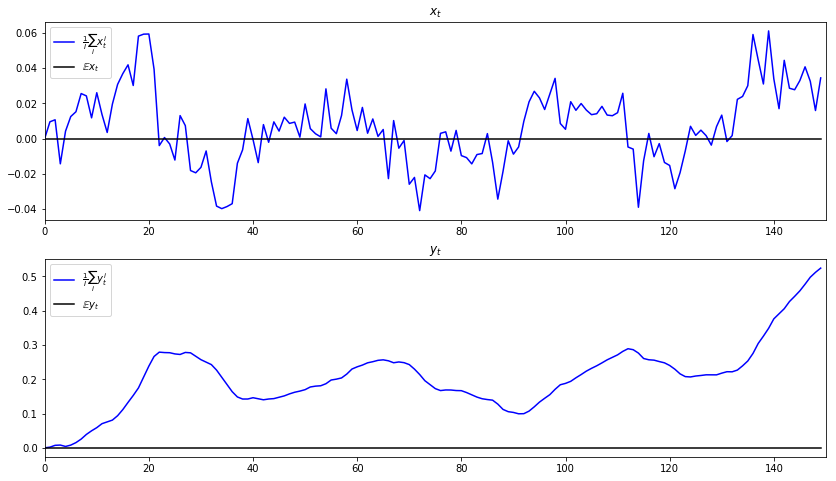

In [3]:
A, B, D, F = [0.8, 1.0, 0.5, 0.2]
amf = AMF_LSS_VAR(A, B, D, F=F)

T = 150
I = 5000

# Simulate and compute sample means
Xit, Yit = simulate_paths(amf, T, I)
Xmean_t = np.mean(Xit, 0)
Ymean_t = np.mean(Yit, 0)

# Compute population means
Xmean_pop, Ymean_pop = population_means(amf, T)

# Plot sample means vs population means
fig, ax = plt.subplots(2, figsize=(14, 8))

ax[0].plot(Xmean_t, label=r'$\frac{1}{I}\sum_i x_t^i$', color="b")
ax[0].plot(Xmean_pop, label='$\mathbb{E} x_t$', color="k")
ax[0].set_title('$x_t$')
ax[0].set_xlim((0, T))
ax[0].legend(loc=0)

ax[1].plot(Ymean_t, label=r'$\frac{1}{I}\sum_i y_t^i$', color="b")
ax[1].plot(Ymean_pop, label='$\mathbb{E} y_t$', color="k")
ax[1].set_title('$y_t$')
ax[1].set_xlim((0, T))
ax[1].legend(loc=0)

plt.show()

### Simulating log-likelihoods

Our next aim is to write a program to simulate $ \{\log L_t \mid \theta_o\}_{t=1}^T $

We want as inputs to this program the *same* sample paths $ \{x_t^i, y_t^i\}_{t=0}^T $ that we  have already computed

We now want to simulate $ I = 5000 $ paths of $ \{\log L_t^i  \mid \theta_o\}_{t=1}^T $

- For each path, we compute $ \log L_T^i / T $  
- We also compute $ \frac{1}{I} \sum_{i=1}^I \log L_T^i / T $  


Then we to compare these objects

Below we plot the histogram of $ \log L_T^i / T $ for realizations $ i = 1, \ldots, 5000 $

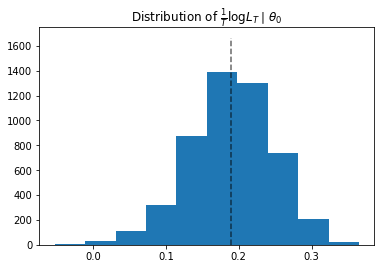

In [4]:
def simulate_likelihood(amf, Xit, Yit):
    # Get size
    I, T = Xit.shape

    # Allocate space
    LLit = np.empty((I, T-1))

    for i in range(I):
        LLit[i, :] = amf.loglikelihood_path(Xit[i, :], Yit[i, :])

    return LLit

# Get likelihood from each path x^{i}, Y^{i}
LLit = simulate_likelihood(amf, Xit, Yit)

LLT = 1/T * LLit[:, -1]
LLmean_t = np.mean(LLT)

fig, ax = plt.subplots()

ax.hist(LLT)
ax.vlines(LLmean_t, ymin=0, ymax=I//3, color="k", linestyle="--", alpha=0.6)
plt.title(r"Distribution of $\frac{1}{T} \log L_{T}  \mid \theta_0$")

plt.show()

Notice that the log likelihood is almost always nonnegative, implying that $ L_t $ is typically bigger than 1

Recall that the likelihood function is a pdf (probability density function) and **not** a probability measure, so it can take values larger than 1

In the current case, the conditional variance of $ \Delta y_{t+1} $, which equals  $ FF^T=0.04 $, is so small that the maximum value of the pdf is 2 (see the figure below)

This implies that approximately $ 75\% $ of the time (a bit more than one sigma deviation),  we should expect the **increment** of the log likelihood to be nonnegative

Let’s see this in a simulation

In [5]:
normdist = sp.stats.norm(0, F)
mult = 1.175
print(f'The pdf at +/- {mult} sigma takes the value:  {normdist.pdf(mult * F)}')
print(f'Probability of dL being larger than 1 is approx: {normdist.cdf(mult * F) - normdist.cdf(-mult * F)}')

# Compare this to the sample analogue:
L_increment = LLit[:, 1:] - LLit[:, :-1]
r, c = L_increment.shape
frac_nonegative = np.sum(L_increment >= 0) / (c * r)
print(f'Fraction of dlogL being nonnegative in the sample is: {frac_nonegative}')

The pdf at +/- 1.175 sigma takes the value:  1.0001868966924388
Probability of dL being larger than 1 is approx: 0.7600052842019751
Fraction of dlogL being nonnegative in the sample is: 0.7600594594594594


Let’s also plot the conditional pdf of $ \Delta y_{t+1} $

The pdf at +/- one sigma takes the value: 1.2098536225957168


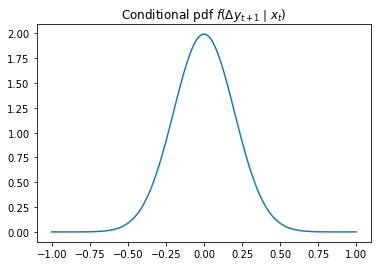

In [6]:
xgrid = np.linspace(-1, 1, 100)
plt.plot(xgrid, normdist.pdf(xgrid))
plt.title('Conditional pdf $f(\Delta y_{t+1} \mid x_t)$')
print(f'The pdf at +/- one sigma takes the value: {normdist.pdf(F)}')
plt.show()

### An alternative parameter vector

Now consider alternative parameter vector $ \theta_1 = [A, B, D, F] = [0.9, 1.0, 0.55, 0.25] $

We want to compute $ \{\log L_t \mid \theta_1\}_{t=1}^T $

The $ x_t, y_t $ inputs to this program should be exactly the **same** sample paths $ \{x_t^i, y_t^i\}_{t=0}^T $ that we we computed above

This is because we want to generate data under the $ \theta_o $ probability model but evaluate the likelihood under the $ \theta_1 $ model

So our task is to use our program to simulate $ I = 5000 $ paths of $ \{\log L_t^i  \mid \theta_1\}_{t=1}^T $

- For each path, compute $ \frac{1}{T} \log L_T^i $  
- Then compute $ \frac{1}{I}\sum_{i=1}^I \frac{1}{T} \log L_T^i $  


We want to compare these objects with each other and with the analogous objects that we computed above

Then we want to interpret outcomes

A function that we constructed can  handle these tasks

The only innovation is that we must create an alternative model to feed in

We will creatively call the new model `amf2`

We make three graphs

- the first sets the stage by repeating an earlier graph  
- the second contains two histograms of values of  log likelihoods of the two models  over the period $ T $  
- the third compares likelihoods under the true and alternative models  


Here’s the code

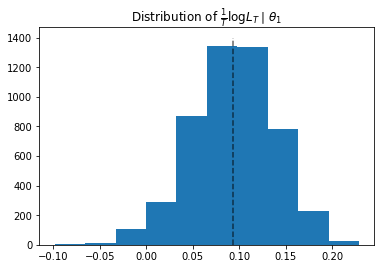

In [7]:
# Create the second (wrong) alternative model
A2, B2, D2, F2 = [0.9, 1.0, 0.55, 0.25]   #  parameters for θ_1 closer to Θ_0
amf2 = AMF_LSS_VAR(A2, B2, D2, F=F2)

# Get likelihood from each path x^{i}, y^{i}
LLit2 = simulate_likelihood(amf2, Xit, Yit)

LLT2 = 1/(T-1) * LLit2[:, -1]
LLmean_t2 = np.mean(LLT2)

fig, ax = plt.subplots()

ax.hist(LLT2)
ax.vlines(LLmean_t2, ymin=0, ymax=1400, color="k", linestyle="--", alpha=0.6)

plt.title(r"Distribution of $\frac{1}{T} \log L_{T}  \mid \theta_1$")
plt.show()

Let’s see a histogram of the log-likelihoods under the true and the alternative model (same sample paths)

/home/quantecon/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


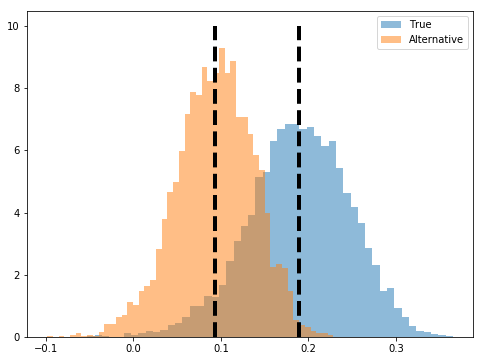

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(LLT, bins=50, alpha=0.5, label='True', normed=True)
plt.hist(LLT2, bins=50, alpha=0.5, label='Alternative', normed=True)
plt.vlines(np.mean(LLT), 0, 10, color='k', linestyle="--", linewidth= 4)
plt.vlines(np.mean(LLT2), 0, 10, color='k', linestyle="--", linewidth= 4)
plt.legend()

plt.show()

Now we’ll plot the histogram of the difference in log likelihood ratio

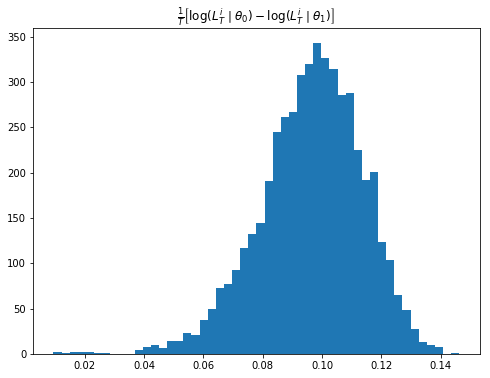

In [9]:
LLT_diff = LLT - LLT2

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(LLT_diff, bins=50)
plt.title(r"$\frac{1}{T}\left[\log (L_T^i  \mid \theta_0) - \log (L_T^i \mid \theta_1)\right]$")

plt.show()

### Interpretation

These histograms of  log likelihood ratios illustrate  important features of **likelihood ratio tests** as tools for discriminating between statistical models

- The log likeklihood is higher on average under the true model – obviously a very useful property  
- Nevertheless, for a positive fraction of realizations, the log likelihood is higher for the incorrect than for the true model  


> - in these instances, a likelihood ratio test mistakenly selects the wrong model  



- These mechanics underlie the statistical theory of **mistake probabilities** associated with model selection tests based on  likelihood ratio  


(In a subsequent lecture, we’ll use some of the code prepared in this lecture to illustrate mistake probabilities)

## Benefits from Reduced Aggregate Fluctuations

Now let’s turn to a new example of multiplicative functionals

This example illustrates  ideas in the literatures on

- **long-run risk** in the consumption based asset pricing literature (e.g., [[BY04]](https://lectures.quantecon.org/py/zreferences.html#bansal-yaron-2004), [[HHL08]](https://lectures.quantecon.org/py/zreferences.html#hhl-2008), [[Han07]](https://lectures.quantecon.org/py/zreferences.html#hansen-2007))  
- **benefits of eliminating aggregate fluctuations** in representative agent macro models (e.g., [[Tal00]](https://lectures.quantecon.org/py/zreferences.html#tall2000), [[Luc03]](https://lectures.quantecon.org/py/zreferences.html#lucas-2003))  


Let $ c_t $ be consumption at date $ t \geq 0 $

Suppose that $ \{\log c_t \}_{t=0}^\infty $ is an additive functional described by

$$
\log c_{t+1} - \log c_t = \nu + D \cdot x_t + F \cdot z_{t+1}
$$

where

$$
x_{t+1} = A x_t + B z_{t+1}
$$

Here $ \{z_{t+1}\}_{t=0}^\infty $ is an i.i.d. sequence of $ {\cal N}(0,I) $ random vectors

A representative household ranks consumption processes $ \{c_t\}_{t=0}^\infty $ with a utility functional $ \{V_t\}_{t=0}^\infty $ that satisfies


<a id='equation-old1mf'></a>
$$
\log V_t - \log c_t = U \cdot x_t + {\sf u} \tag{1}
$$

where

$$
U = \exp(-\delta) \left[ I - \exp(-\delta) A' \right]^{-1} D
$$

and

$$
{\sf u}
  = {\frac {\exp( -\delta)}{ 1 - \exp(-\delta)}} {\nu} + \frac{(1 - \gamma)}{2} {\frac {\exp(-\delta)}{1 - \exp(-\delta)}}
\biggl| D' \left[ I - \exp(-\delta) A \right]^{-1}B + F \biggl|^2,
$$

Here $ \gamma \geq 1 $ is a risk-aversion coefficient and $ \delta > 0 $ is a rate of time preference

### Consumption as a multiplicative process

We begin by showing that consumption is a **multiplicative functional** with representation


<a id='equation-old2mf'></a>
$$
\frac{c_t}{c_0}
= \exp(\tilde{\nu}t )
\left( \frac{\tilde{M}_t}{\tilde{M}_0} \right)
\left( \frac{\tilde{e}(x_0)}{\tilde{e}(x_t)} \right) \tag{2}
$$

where $ \left( \frac{\tilde{M}_t}{\tilde{M}_0} \right) $ is a likelihood ratio process and $ \tilde M_0 = 1 $

At this point, as an exercise, we ask the reader please to verify the follow formulas for $ \tilde{\nu} $ and $ \tilde{e}(x_t) $ as functions of $ A, B, D, F $:

$$
\tilde \nu =  \nu + \frac{H \cdot H}{2}
$$

and

$$
\tilde e(x) = \exp[g(x)] = \exp \bigl[ D' (I - A)^{-1} x \bigr]
$$

### Simulating a likelihood ratio process again

Next, we want a program to simulate the likelihood ratio process $ \{ \tilde{M}_t \}_{t=0}^\infty $

In particular, we want to simulate 5000 sample paths of length $ T=1000 $ for the case in which $ x $ is a scalar and $ [A, B, D, F] = [0.8, 0.001, 1.0, 0.01] $ and $ \nu = 0.005 $

After accomplishing this, we want to display a histogram of $ \tilde{M}_T^i $ for
$ T=1000 $

Here is code that accomplishes these tasks

In [10]:
def simulate_martingale_components(amf, T=1000, I=5000):
    # Get the multiplicative decomposition
    ν, H, g = amf.multiplicative_decomp()

    # Allocate space
    add_mart_comp = np.empty((I, T))

    # Simulate and pull out additive martingale component
    for i in range(I):
        foo, bar = amf.lss.simulate(T)

        # Martingale component is third component
        add_mart_comp[i, :] = bar[2, :]

    mul_mart_comp = np.exp(add_mart_comp - (np.arange(T) * H**2) / 2)

    return add_mart_comp, mul_mart_comp


# Build model
amf_2 = AMF_LSS_VAR(0.8, 0.001, 1.0, 0.01,.005)

amc, mmc = simulate_martingale_components(amf_2, 1000, 5000)

amcT = amc[:, -1]
mmcT = mmc[:, -1]

print("The (min, mean, max) of additive Martingale component in period T is")
print(f"\t ({np.min(amcT)}, {np.mean(amcT)}, {np.max(amcT)})")

print("The (min, mean, max) of multiplicative Martingale component in period T is")
print(f"\t ({np.min(mmcT)}, {np.mean(mmcT)}, {np.max(mmcT)})")

The (min, mean, max) of additive Martingale component in period T is
	 (-1.7128360641004454, 0.0024988985194013998, 1.6504587721324488)
The (min, mean, max) of multiplicative Martingale component in period T is
	 (0.16118160568079276, 0.9985826109110277, 4.655602216283844)


#### Comments

- The preceding min, mean, and max of the cross-section of the date
  $ T $ realizations of the multiplicative martingale component of
  $ c_t $ indicate that the sample mean is close to its population
  mean of 1  
  
  - This outcome prevails for all values of the horizon $ T $  
  
- The cross-section distribution of the multiplicative martingale
  component of $ c $ at date $ T $ approximates a log normal
  distribution well  
- The histogram of the additive martingale component of
  $ \log c_t $ at date $ T $ approximates a normal distribution
  well  


Here’s a histogram of the additive martingale component

/home/quantecon/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


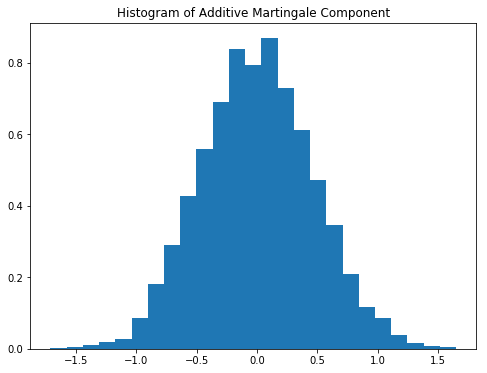

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(amcT, bins=25, normed=True)
plt.title("Histogram of Additive Martingale Component")

plt.show()

Here’s a histogram of the multiplicative martingale component

/home/quantecon/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


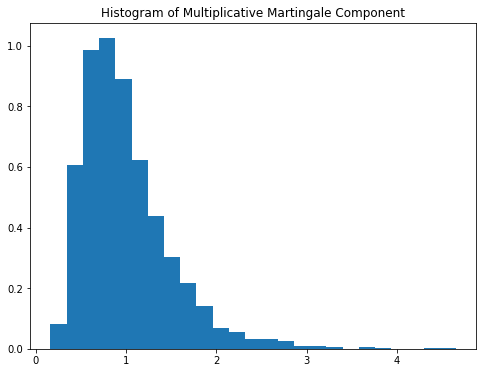

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(mmcT, bins=25, normed=True)
plt.title("Histogram of Multiplicative Martingale Component")
plt.show()

### Representing the likelihood ratio process

The likelihood ratio process $ \{\widetilde M_t\}_{t=0}^\infty $ can be represented as

$$
\widetilde M_t = \exp \biggl( \sum_{j=1}^t \biggl(H \cdot z_j -\frac{ H \cdot H }{2} \biggr) \biggr),  \quad \widetilde M_0 =1 ,
$$

where $ H =  [F + B'(I-A')^{-1} D] $

It follows that $ \log {\widetilde M}_t \sim {\mathcal N} ( -\frac{t H \cdot H}{2}, t H \cdot H ) $ and that consequently $ {\widetilde M}_t $ is log normal

Let’s plot the probability density functions for $ \log {\widetilde M}_t $ for
$ t=100, 500, 1000, 10000, 100000 $

Then let’s use the plots to  investigate how these densities evolve through time

We will plot the densities of $ \log {\widetilde M}_t $ for different values of $ t $

Note: `scipy.stats.lognorm` expects you to pass the standard deviation
first $ (tH \cdot H) $ and then the exponent of the mean as a
keyword argument `scale` (`scale=`$ \exp(-tH \cdot H/2) $)

- See the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html#scipy.stats.lognorm)  


This is peculiar, so make sure you are careful in working with the log normal distribution

Here is some code that tackles these tasks

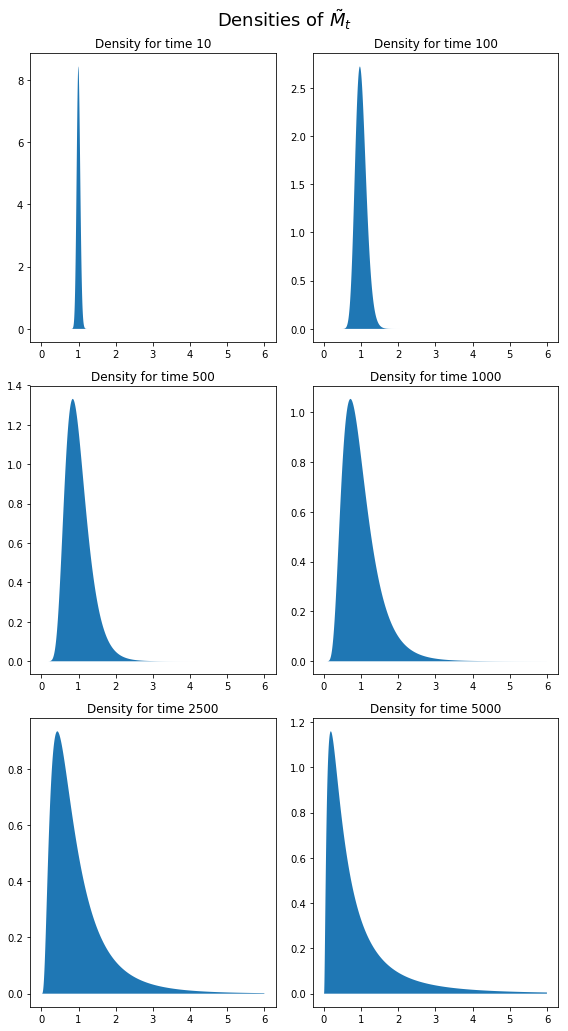

In [13]:
def Mtilde_t_density(amf, t, xmin=1e-8, xmax=5.0, npts=5000):

    # Pull out the multiplicative decomposition
    νtilde, H, g = amf.multiplicative_decomp()
    H2 = H * H

    # The distribution
    mdist = lognorm(np.sqrt(t * H2), scale=np.exp(-t * H2 / 2))
    x = np.linspace(xmin, xmax, npts)
    pdf = mdist.pdf(x)

    return x, pdf


def logMtilde_t_density(amf, t, xmin=-15.0, xmax=15.0, npts=5000):

    # Pull out the multiplicative decomposition
    νtilde, H, g = amf.multiplicative_decomp()
    H2 = H * H

    # The distribution
    lmdist = norm(-t * H2 / 2, np.sqrt(t * H2))
    x = np.linspace(xmin, xmax, npts)
    pdf = lmdist.pdf(x)

    return x, pdf


times_to_plot = [10, 100, 500, 1000, 2500, 5000]
dens_to_plot = map(lambda t: Mtilde_t_density(amf_2, t, xmin=1e-8, xmax=6.0), times_to_plot)
ldens_to_plot = map(lambda t: logMtilde_t_density(amf_2, t, xmin=-10.0, xmax=10.0), times_to_plot)

fig, ax = plt.subplots(3, 2, figsize=(8, 14))
ax = ax.flatten()

fig.suptitle(r"Densities of $\tilde{M}_t$", fontsize=18, y=1.02)
for (it, dens_t) in enumerate(dens_to_plot):
    x, pdf = dens_t
    ax[it].set_title(f"Density for time {times_to_plot[it]}")
    ax[it].fill_between(x, np.zeros_like(pdf), pdf)

plt.tight_layout()
plt.show()

These probability density functions illustrate a **peculiar property** of log likelihood ratio processes:

- With respect to the true model probabilities, they have mathematical expectations equal to $ 1 $ for all $ t \geq 0 $  
- They almost surely converge to zero  

### Welfare benefits of reduced random aggregate fluctuations

Suppose in the tradition of a strand of macroeconomics (for example Tallarini [[Tal00]](https://lectures.quantecon.org/py/zreferences.html#tall2000), [[Luc03]](https://lectures.quantecon.org/py/zreferences.html#lucas-2003)) we want to estimate the welfare benefits from removing random fluctuations around trend growth

We shall  compute how much initial consumption $ c_0 $ a representative consumer who ranks consumption streams according to [(1)](#equation-old1mf) would be willing to sacrifice to enjoy the consumption stream

$$
\frac{c_t}{c_0} = \exp (\tilde{\nu} t)
$$

rather than the stream described by equation [(2)](#equation-old2mf)

We want to compute the implied percentage reduction in $ c_0 $ that the representative consumer would accept

To accomplish this, we write a function that computes the coefficients $ U $
and $ u $ for the original values of $ A, B, D, F, \nu $, but
also for the case that  $ A, B, D, F = [0, 0, 0, 0] $ and
$ \nu = \tilde{\nu} $

Here’s our code

In [14]:
def Uu(amf, δ, γ):
    A, B, D, F, ν = amf.A, amf.B, amf.D, amf.F, amf.ν
    ν_tilde, H, g = amf.multiplicative_decomp()

    resolv = 1 / (1 - np.exp(-δ) * A)
    vect = F + D * resolv * B

    U_risky = np.exp(-δ) * resolv * D
    u_risky = (np.exp(-δ) / (1 - np.exp(-δ))) * (ν + (.5) * (1 - γ) * (vect**2))

    U_det = 0
    u_det = (np.exp(-δ) / (1 - np.exp(-δ))) * ν_tilde

    return U_risky, u_risky, U_det, u_det

# Set remaining paramaters
δ = 0.02
γ = 2.0

# Get coeffs
U_r, u_r, U_d, u_d = Uu(amf_2, δ, γ)

The values of the two processes are

$$
\begin{aligned}
    \log V^r_0 &= \log c^r_0 + U^r x_0 + u^r
     \\
    \log V^d_0 &= \log c^d_0 + U^d x_0 + u^d
\end{aligned}
$$

We look for the ratio $ \frac{c^r_0-c^d_0}{c^r_0} $ that makes
$ \log V^r_0 - \log V^d_0 = 0 $

$$
\begin{aligned}
    \underbrace{ \log V^r_0 - \log V^d_0}_{=0} + \log c^d_0 - \log c^r_0
      &= (U^r-U^d) x_0 + u^r - u^d
    \\
 \frac{c^d_0}{ c^r_0}
     &= \exp\left((U^r-U^d) x_0 + u^r - u^d\right)
\end{aligned}
$$

Hence, the implied percentage reduction in $ c_0 $ that the
representative consumer would accept is given by

$$
\frac{c^r_0-c^d_0}{c^r_0} = 1 - \exp\left((U^r-U^d) x_0 + u^r - u^d\right)
$$

Let’s compute this

In [15]:
x0 = 0.0  # initial conditions
logVC_r = U_r * x0 + u_r
logVC_d = U_d * x0 + u_d

perc_reduct = 100 * (1 - np.exp(logVC_r - logVC_d))
perc_reduct

1.0809878812017448

We find that the consumer would be willing to take a percentage reduction of initial consumption equal to around 1.081